In [31]:
import numpy as np
import pandas as pd
from datetime import date, time
import matplotlib.pyplot as plt
# check if there is data missing
from feature_engine.creation import CyclicalFeatures

In [54]:
def load_data():
    df = pd.read_csv('air+quality/AirQualityUCI.csv', sep=';')

    # Selecting only the variable that we gonna use in this project
    variables = ['Date', 'Time', 'PT08.S1(CO)', 'RH']

    # Filtering only the variables selected
    df = df[variables]

    # Replacing the "." symbols inside my Time column to ":"
    df['Time'] = df['Time'].str.replace('.', ':', regex=False)

    # Joining the two columns "Date" and "Time" into a single Date_Time column
    df['Date_Time'] = df['Date'] + ' ' + df['Time']

    # Casting the "Date_Time" column that are 
    df['Date_Time'] = pd.to_datetime(df['Date_Time'], format='%d/%m/%Y %H:%M:%S')

    # Setting the column "Date_Time" as the index of the Dataframe
    df = df.set_index(df['Date_Time'])

    # Discarding the columns "Date", "Time" and "Date_Time"
    df = df.drop(columns=['Date', 'Time', 'Date_Time'])

    # Renaming a the column "PT08.S1(CO)" to "CO_sensor" for simplicity purposes
    df = df.rename(columns={'PT08.S1(CO)':'CO_sensor'})

    # Replacing the "," to "." 
    df['RH'] = df['RH'].str.replace(",", ".", regex=False)

    # Casting the values of "RH" column as numeric
    df['RH'] = pd.to_numeric(df['RH'])

    # Reduce data span (poor data quality outside these dates)
    df = df.loc["2004-04-04":"2005-04-04"]

    return df

df = load_data()
variables_t = ['CO_sensor', 'RH']

In [46]:
# Checking the shape of out dataframe
df.shape

(8775, 2)

In [194]:
# Sanity check: data span
df.index.min(), df.index.max()

(Timestamp('2004-04-04 00:00:00'), Timestamp('2005-04-04 14:00:00'))

In [195]:
# Quick check: missing data
df.isnull().sum()

CO_sensor    0
RH           0
dtype: int64

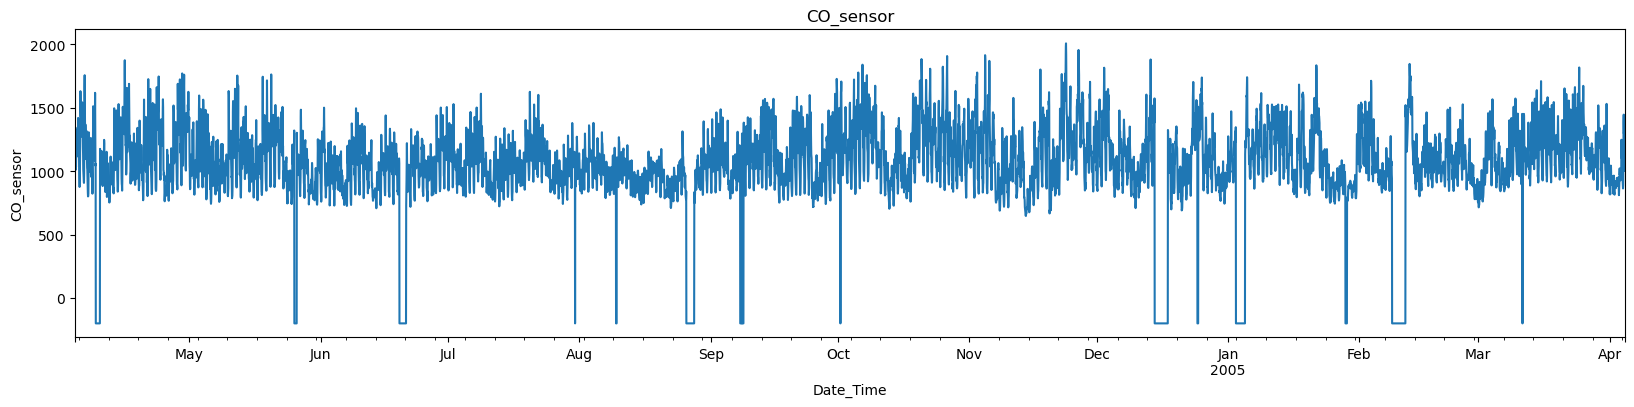

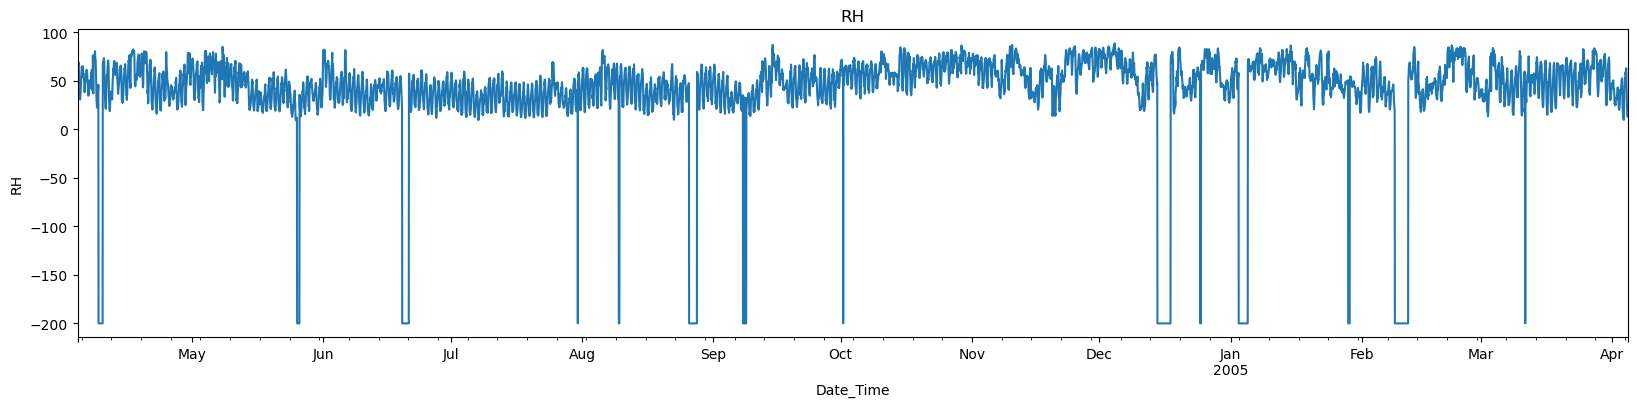

In [3]:
for var in ['CO_sensor', 'RH']:
    # Plot the time series
    df[var].plot(figsize=(20,4))
    
    # Add title
    plt.title(var)
    
    # the y axis label
    plt.ylabel(var)
    
    plt.show()

### As we can see there are a lot negative data at the CO_sensor series, as there are not possible to gave negative values of CO these value are considerable outliers and we can remove them

In [55]:
# Removing outliers
df = df.loc[(df['CO_sensor'] >= 0) & (df['RH'] >= 0)]

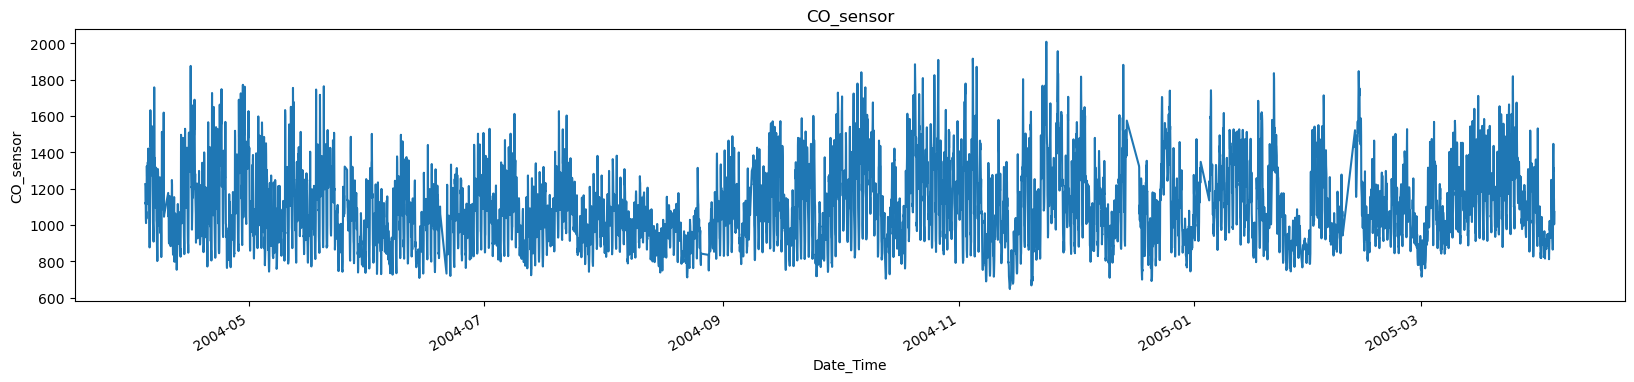

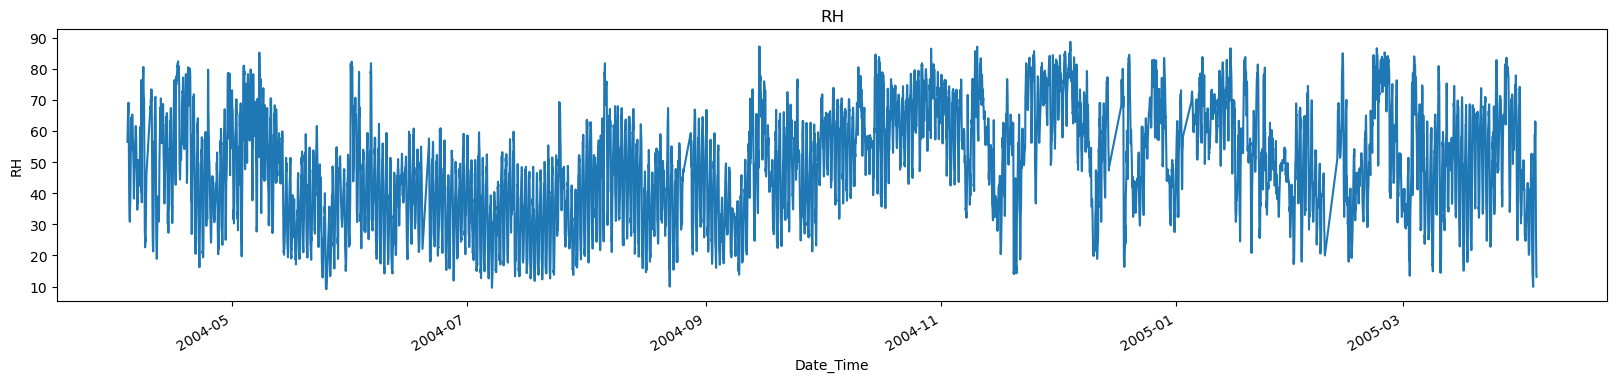

In [35]:
# Running again the plots to check how they are after the outliers removing
for var in ['CO_sensor', 'RH']:
    # Plot the time series
    df[var].plot(figsize=(20,4))
    # Add title
    plt.title(var)
    # the y axis label
    plt.ylabel(var)
    plt.show()

### In the plot below we can see which values are **EMPTY** in red

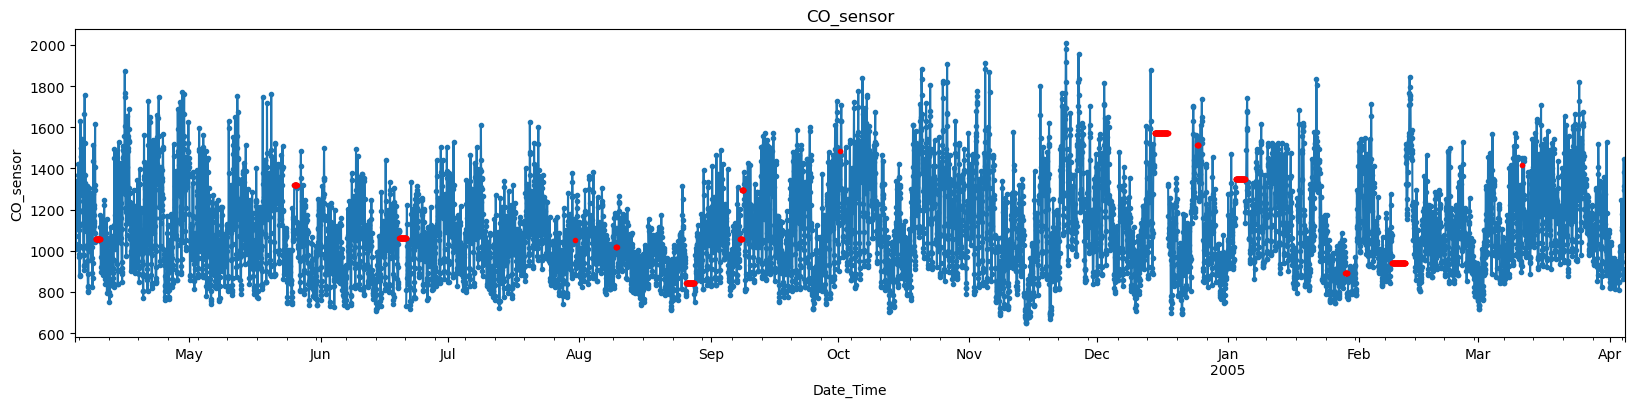

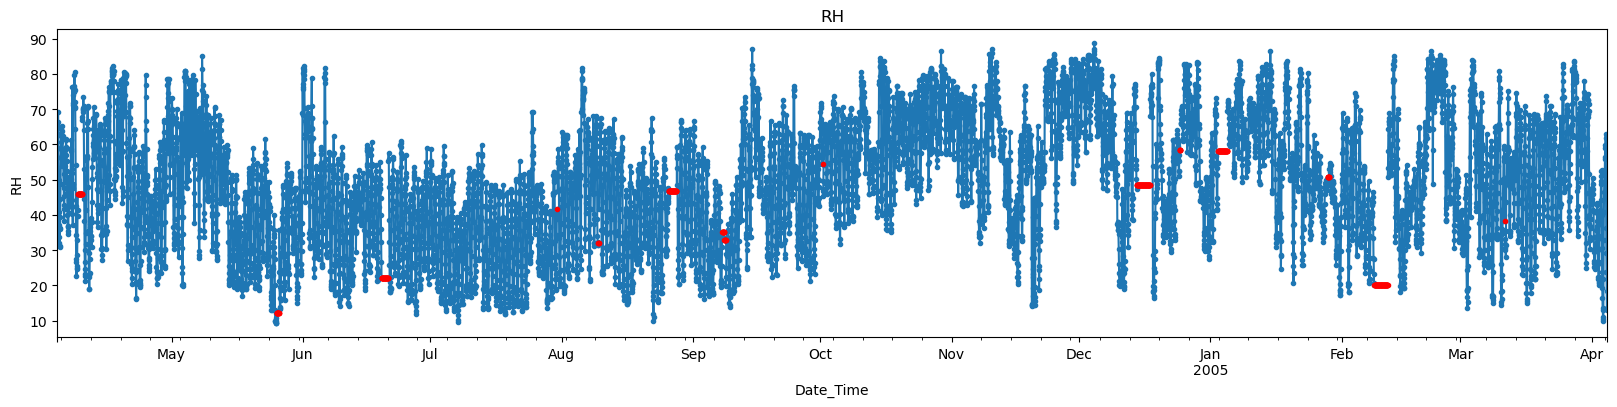

In [59]:
# Introduce the missing timestamps
# Note that we capture this a different dataframe.
df_ = df.asfreq("1H")

# Apply the foward fill method.
data_imputed = df_.fillna(method='ffill')

# Plot the imputed time series.
for var in variables_t:
    
    # plot the time series
    ax = df_[var].plot(linestyle="-", marker=".", figsize=[20,4])
    
    # plot the imputed values on top, in red.
    data_imputed[df_.isnull()][var].plot(ax=ax, legend=None, marker=".", color="r")
    
    # Add title
    plt.title(var)
    
    # the y axis label
    plt.ylabel(var)
    
    plt.show()


# Seasonality

### Air pollutant concentration changes with car traffic. At rush hour, we have more pollutants. During the night hours, we have fewer polluttants.

### Let's see if what I am saying is true.

In [60]:
# Capture "time" in a new variable.
time_ = df.index.time
# transforming the variable time_ extracted in a pandas Series
time_ = pd.Series(time_, index = df.index)

time_.head()

Date_Time
2004-04-04 00:00:00    00:00:00
2004-04-04 01:00:00    01:00:00
2004-04-04 02:00:00    02:00:00
2004-04-04 03:00:00    03:00:00
2004-04-04 04:00:00    04:00:00
dtype: object

Text(0, 0.5, 'Concentration')

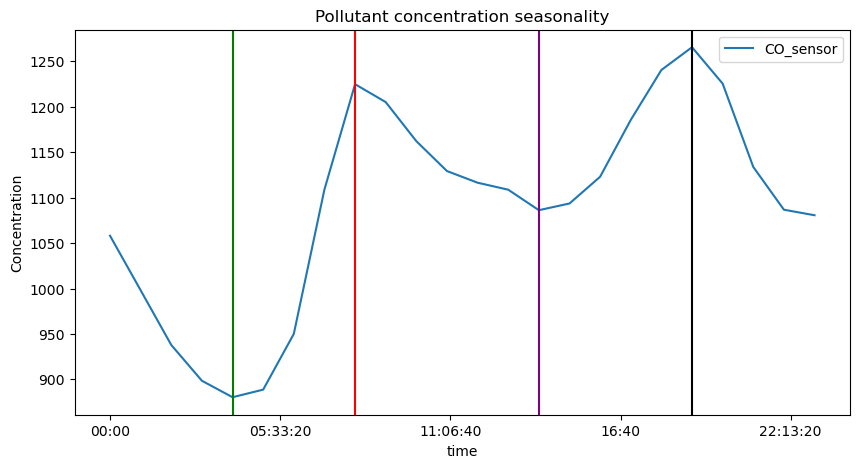

In [65]:
# Plot the average pollutant concentration per hour
df.groupby(time_)[['CO_sensor']].mean().plot(figsize=(10, 5))
plt.axvline(x=time_[4], color = 'green')
plt.axvline(x=time_[8], color = 'red')
plt.axvline(x=time_[14], color = 'purple')
plt.axvline(x=time_[19], color = 'black')
plt.title('Pollutant concentration seasonality')
plt.ylabel('Concentration')

## As we can see in the plot above the time when the air polution has a peak is between 05:33 - 11:06 and 16:40 - 22:13

Text(0, 0.5, 'Concentration')

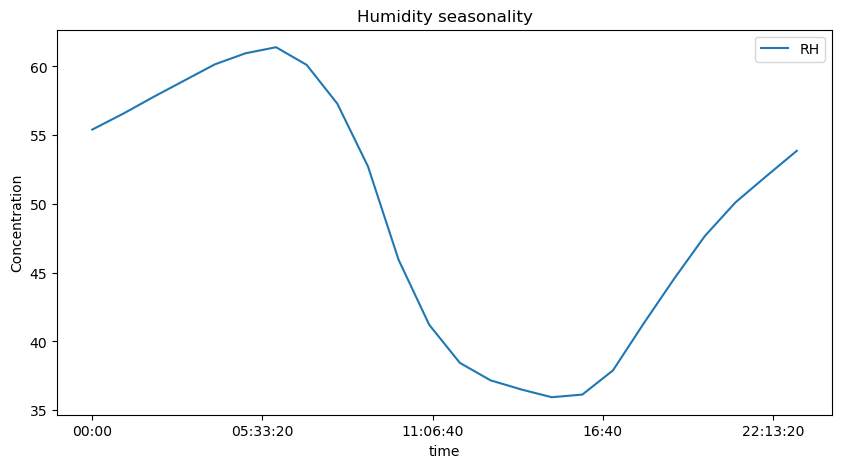

In [39]:
# Plot the average humiodity concentration per hour
df.groupby(time_)[['RH']].mean().plot(figsize=(10, 5))
# Setup the title of the plot
plt.title('Humidity seasonality')
# Setup the ylabel of the plot
plt.ylabel('Concentration')

In [66]:
# Sort index
df.sort_index(inplace=True)

- timestamp in the index.
- CO_sensor: carbon monixide concentration
- RH: relative humidity (in the air)

# Extract time related features (Future known features)

- These are features that captures information from timestamp

In [67]:
# Extract date and time features
df['month'] = df.index.month # getting the month from timestamp
df['week'] = df.index.isocalendar().week # getting the week from timestamp
df['day'] = df.index.day #getting day from timestamp
df['day_of_year'] = df.index.dayofyear #getting day from timestamp
df['day_of_week'] = df.index.day_of_week # getting day of week from timestamp
df['hour'] = df.index.hour # getting hour from timestamp

# If is weekend or not
df['is_weekend'] = np.where(df['day_of_week'] > 4, 1, 0)

df.head()

,CO_sensor,RH,month,week,day,day_of_year,day_of_week,hour,is_weekend
Date_Time,,,,,,,,,
2004-04-04 00:00:00,1224.0,56.5,4,14,4,95,6,0,1
2004-04-04 01:00:00,1215.0,59.2,4,14,4,95,6,1,1
2004-04-04 02:00:00,1115.0,62.4,4,14,4,95,6,2,1
2004-04-04 03:00:00,1124.0,65.0,4,14,4,95,6,3,1
2004-04-04 04:00:00,1028.0,65.3,4,14,4,95,6,4,1


## Before going further we have to split the data in "train" and "test" to avoid data leakage

In [68]:
# We will keep the last month of the test
# the forecasting models.
train = df[df.index <= "2005-03-04"]
test = df[df.index > "2005-03-04"]

train.shape, test.shape

((7655, 9), (757, 9))

### Extracting these features could be beneficial as pollutant concentrations may vary significantly across different times, showing distinct patterns of variability. Specifically, it is observed that pollutant levels tend to be higher during the winter months. This seasonal variation is attributed to various factors, including atmospheric conditions and heating emissions. Additionally, there is evidence of weekly seasonality, with higher pollution levels during weekdays, likely due to increased vehicular traffic. Moreover, as illustrated in the plots provided, there is an hourly seasonality, with peaks in pollutant concentrations occurring during rush hours. These patterns underscore the importance of considering temporal dynamics when analyzing pollutant concentrations, to better understand their environmental and health impacts.

# Lag Features

In [69]:
# Here, I show how to move foward by, 1 hr,
# so that the pollutant concentration from the previous
# hour (t-1) is alligned with the current hour (t),
# which is the timestamp we want to make predictions about
def lag_features_1(df):
    # Shift the data foward 1 Hr
    tmp = df[variables_t].shift(freq='1H')
    # Name the new variables
    tmp.columns = [v + '_lag_1' for v in variables_t]
    # Add the variables to the original data.
    print('data size before')
    print(df.shape)
    df = df.merge(tmp, left_index=True, right_index=True, how='left')
    print('data size after')
    print(df.shape)
    df[['CO_sensor', 'CO_sensor_lag_1']].head()
    return df

train = lag_features_1(train)
test = lag_features_1(test)

data size before
(7655, 9)
data size after
(7655, 11)
data size before
(757, 9)
data size after
(757, 11)


In [71]:
# Here, I show how to move foward by, 24 hr,
# so that the pollutant concentration from the previous
# hour (t-24) is alligned with the current hour (t),
# which is the timestamp we want to make predictions about
def lag_features_24(df):
    # Shift the data foward 24 Hr
    tmp = df[variables_t].shift(freq='24H')
    # Name the new variables
    tmp.columns = [v + '_lag_24' for v in variables_t]
    # Add the variables to the original data.
    print('data size before')
    print(df.shape)
    df = df.merge(tmp, left_index=True, right_index=True, how='left')
    print('data size after')
    print(df.shape)
    df[['CO_sensor', 'CO_sensor_lag_24']].head()
    return df

In [72]:
train = lag_features_24(train)
test = lag_features_24(test)

data size before
(7655, 11)
data size after
(7655, 13)
data size before
(757, 11)
data size after
(757, 13)


In [73]:
# Here, I show how to move foward by, 5, 8, 19 hr,
# so that the pollutant concentration from the previous
# hour (t-5, t-8, t-19) is alligned with the current hour (t),
# which is the timestamp we want to make predictions about

# Analysing the daily seasonality of air pollutant we noticed a valley at the hour 5, 14 and peaks at 8 and 19.
def lag_features_5_14_8_19(df):
    # Shift the data foward 24 Hr
    tmp = df[variables_t].shift(freq='5H')
    # Name the new variables
    tmp.columns = [v + '_lag_5' for v in variables_t]
    # Add the variables to the original data.
    print('data size before')
    print(df.shape)
    df = df.merge(tmp, left_index=True, right_index=True, how='left')
    print('data size after')
    print(df.shape)
    
    # Shift the data foward 24 Hr
    tmp = df[variables_t].shift(freq='14H')
    # Name the new variables
    tmp.columns = [v + '_lag_14' for v in variables_t]
    # Add the variables to the original data.
    print('data size before')
    print(df.shape)
    df = df.merge(tmp, left_index=True, right_index=True, how='left')
    print('data size after')
    print(df.shape)
    
    # Shift the data foward 24 Hr
    tmp = df[variables_t].shift(freq='8H')
    # Name the new variables
    tmp.columns = [v + '_lag_8' for v in variables_t]
    # Add the variables to the original data.
    print('data size before')
    print(df.shape)
    df = df.merge(tmp, left_index=True, right_index=True, how='left')
    print('data size after')
    print(df.shape)
    
    # Shift the data foward 24 Hr
    tmp = df[variables_t].shift(freq='19H')
    # Name the new variables
    tmp.columns = [v + '_lag_19' for v in variables_t]
    # Add the variables to the original data.
    print('data size before')
    print(df.shape)
    df = df.merge(tmp, left_index=True, right_index=True, how='left')
    print('data size after')
    print(df.shape)
    
    return df

In [76]:
train = lag_features_5_14_8_19(train)
test = lag_features_5_14_8_19(test)

data size before
(7655, 21)
data size after
(7655, 23)
data size before
(7655, 23)
data size after
(7655, 25)
data size before
(7655, 25)
data size after
(7655, 27)
data size before
(7655, 27)
data size after
(7655, 29)
data size before
(757, 21)
data size after
(757, 23)
data size before
(757, 23)
data size after
(757, 25)
data size before
(757, 25)
data size after
(757, 27)
data size before
(757, 27)
data size after
(757, 29)


In [78]:
# In this procedure, we introduced missing
# data whenever there was no data available in
# the previous 24 hours.

df.isnull().sum()


CO_sensor      0
RH             0
month          0
week           0
day            0
day_of_year    0
day_of_week    0
hour           0
is_weekend     0
dtype: int64

# Windows features

### Windows features are statistical computations of value that occur prior to the time that we want to forecast.
### If I want to make forecast at time t, I can use the average of the dos 3, 6, 9 or whatever last values.
### There are a lot of statistical parameters tha we can extract from these windows.

### We first need to calculate the average of the 3 previous values, and then move that value foward

In [212]:
# Use the mean of the 3 previous hours as input variables.
def window_features_mean_3(df):
    tmp = (df[variables_t]
           .rolling(window='3H').mean() # Average the last 3 hr values.
           .shift(freq='1H') # Move the average 1 step foward
          )
    # Rename the columns
    tmp.columns = [v + '_window_mean_3' for v in variables_t]
    # view of the result
    tmp.head(10)
    # Join the variables to the original df.
    print('df size before')
    print(df.shape)
    # Merging the new calculated columns with out df. using 'left' parameter for out new data to 'adapt' in our previous formating.
    df = df.merge(tmp, left_index=True, right_index=True, how='left')
    print('df size after')
    print(df.shape)
    return df

In [213]:
train = window_features_mean_3(train)
test = window_features_mean_3(test)

df size before
(7655, 13)
df size after
(7655, 15)
df size before
(757, 13)
df size after
(757, 15)


In [79]:
# Use the mean of the 5 previous hours as input variables.
def window_features_mean_5(df):
    tmp = (df[variables_t]
           .rolling(window='5H').mean() # Average the last 3 hr values.
           .shift(freq='1H') # Move the average 1 step foward
          )
    # Rename the columns
    tmp.columns = [v + '_window_mean_5' for v in variables_t]
    # view of the result
    tmp.head(10)
    # Join the variables to the original df.
    print('df size before')
    print(df.shape)
    # Merging the new calculated columns with out df. using 'left' parameter for out new data to 'adapt' in our previous formating.
    df = df.merge(tmp, left_index=True, right_index=True, how='left')
    print('df size after')
    print(df.shape)
    return df

In [80]:
train = window_features_mean_5(train)
test = window_features_mean_5(test)

df size before
(7655, 29)
df size after
(7655, 31)
df size before
(757, 29)
df size after
(757, 31)


In [83]:
# Use the standard deviation of the 3 previous hours as input variables.
def window_features_std_3(df):
    tmp = (df[variables_t]
           .rolling(window='3H').std() # Average the last 3 hr values.
           .shift(freq='1H') # Move the average 1 step foward
          )
    # Rename the columns
    tmp.columns = [v + '_window_std_3' for v in variables_t]
    # Join the variables to the original df.
    print('df size before')
    print(df.shape)
    # Merging the new calculated columns with out df. using 'left' parameter for out new data to 'adapt' in our previous formating.
    df = df.merge(tmp, left_index=True, right_index=True, how='left')
    print('df size after')
    print(df.shape)
    return df

In [215]:
train = window_features_std_3(train)
test = window_features_std_3(test)

df size before
(7655, 15)
df size after
(7655, 17)
df size before
(757, 15)
df size after
(757, 17)


In [85]:
# Use the standard deviation of the 5 previous hours as input variables.
def window_features_std_5(df):
    tmp = (df[variables_t]
           .rolling(window='5H').std() # Average the last 3 hr values.
           .shift(freq='1H') # Move the average 1 step foward
          )
    # Rename the columns
    tmp.columns = [v + '_window_std_5' for v in variables_t]
    # Join the variables to the original df.
    print('df size before')
    print(df.shape)
    # Merging the new calculated columns with out df. using 'left' parameter for out new data to 'adapt' in our previous formating.
    df = df.merge(tmp, left_index=True, right_index=True, how='left')
    print('df size after')
    print(df.shape)
    return df

In [86]:
train = window_features_std_5(train)
test = window_features_std_5(test)

df size before
(7655, 31)
df size after
(7655, 33)
df size before
(757, 31)
df size after
(757, 33)


In [87]:
train.head(6)

,CO_sensor,RH,month,week,day,day_of_year,day_of_week,hour,is_weekend,CO_sensor_lag_1,...,CO_sensor_lag_14_y,RH_lag_14_y,CO_sensor_lag_8_y,RH_lag_8_y,CO_sensor_lag_19_y,RH_lag_19_y,CO_sensor_window_mean_5,RH_window_mean_5,CO_sensor_window_std_5,RH_window_std_5
Date_Time,,,,,,,,,,,,,,,,,,,,,
2004-04-04 00:00:00,1224.0,56.5,4,14,4,95,6,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-04-04 01:00:00,1215.0,59.2,4,14,4,95,6,1,1,1224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1224.000000,56.500000,NaN,NaN
2004-04-04 02:00:00,1115.0,62.4,4,14,4,95,6,2,1,1215.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1219.500000,57.850000,6.363961,1.909188
2004-04-04 03:00:00,1124.0,65.0,4,14,4,95,6,3,1,1115.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1184.666667,59.366667,60.500689,2.953529
2004-04-04 04:00:00,1028.0,65.3,4,14,4,95,6,4,1,1124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1169.500000,60.775000,57.968382,3.707987
2004-04-04 05:00:00,1010.0,66.5,4,14,4,95,6,5,1,1028.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1141.200000,61.680000,80.775615,3.795655


# Periodic Features

### Some features are periodic. For example, hours, months, and days.

### We can encode those periodic features using sine and cosine transformation with the feature's period. This will cause the value of the features that are far apart to come closer.
### For example, December (12) is closer to January (1) then June (6). 
### This relationship is not captured by numerical representation of these features.
### But we could change it if we transformed there variables with sine and cosine.

In [88]:
df[['month', 'hour']].isnull().sum()

month    0
hour     0
dtype: int64

In [89]:
def periodic_features(df):
    # Create features that capture the cyclical representation
    cyclical = CyclicalFeatures(
        variables=['month', 'hour'], # The features we want to transform.
        drop_original=False, # Whether to drop the original features.
    )
    # Applying the transformations
    df = cyclical.fit_transform(df)
    # Now after this transformations we are capturing the fact that january is closer to december than to June and the same for the hour we a capturing the fact that 0 is closer to 24 than to to 6  
    cyclical_vars = [var for var in df.columns if 'sin' in var or 'cos' in var]
    return df

train = periodic_features(train)
test = periodic_features(test)

In [91]:
train.shape, test.shape

((7655, 37), (757, 37))

In [90]:
cyclical_vars = [var for var in train.columns if 'sin' in var or 'cos' in var]
train[cyclical_vars].head()

,month_sin,month_cos,hour_sin,hour_cos
Date_Time,,,,
2004-04-04 00:00:00,0.866025,-0.5,0.000000,1.000000
2004-04-04 01:00:00,0.866025,-0.5,0.269797,0.962917
2004-04-04 02:00:00,0.866025,-0.5,0.519584,0.854419
2004-04-04 03:00:00,0.866025,-0.5,0.730836,0.682553
2004-04-04 04:00:00,0.866025,-0.5,0.887885,0.460065


# Drop missing data

In [92]:
# Determine fraction of missing data
print('Train: ')
print(100*(train.isnull().sum() / len(train)))
print()
print('Test: ')
print(100*(train.isnull().sum() / len(train)))

Train: 
CO_sensor                  0.000000
RH                         0.000000
month                      0.000000
week                       0.000000
day                        0.000000
day_of_year                0.000000
day_of_week                0.000000
hour                       0.000000
is_weekend                 0.000000
CO_sensor_lag_1            0.195950
RH_lag_1                   0.195950
CO_sensor_lag_24           2.873939
RH_lag_24                  2.873939
CO_sensor_lag_5_x          0.809928
RH_lag_5_x                 0.809928
CO_sensor_lag_14_x         1.894187
RH_lag_14_x                1.894187
CO_sensor_lag_8_x          1.201829
RH_lag_8_x                 1.201829
CO_sensor_lag_19_x         2.416721
RH_lag_19_x                2.416721
CO_sensor_lag_5_y          0.809928
RH_lag_5_y                 0.809928
CO_sensor_lag_14_y         1.894187
RH_lag_14_y                1.894187
CO_sensor_lag_8_y          1.201829
RH_lag_8_y                 1.201829
CO_sensor_lag_19_y  

# Imputation

There is a lot of data missing, so I will just remove those observations

In [93]:

# Train dropna
print('train size before')
print(train.shape)
train.dropna(inplace=True)
print('train size after')
print(train.shape)

# Test dropna
print('test size before')
print(test.shape)
test.dropna(inplace=True)
print('test size after')
print(test.shape)

train size before
(7655, 37)
train size after
(7359, 37)
test size before
(757, 37)
test size after
(727, 37)


# Save preprocessed data

In [95]:
# Now we have passed to a bigger dataset that contains a lot of features 
# derived from the timestamp and from past values of the carbon monoxide 
# and relative humidity respect to forecast point and thats we are going 
# to use to try and predict the carbon monoxide.

# drop relative humidity raw (we do not know its values at time of forecast) 
train.drop("RH", inplace=True, axis=1)
test.drop("RH", inplace=True, axis=1)

In [97]:
# Store new dataset
train.to_csv("train-air-qual-preprocessed.csv", index=True)
test.to_csv("test-air-qual-preprocessed.csv", index=True)